In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

tf.test.is_gpu_available()

2.0.0-dev20191002
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0-dev20191002
tensorflow_core.keras 2.2.4-tf
Instructions for updating:
Use `tf.config.experimental.list_physical_devices('GPU')` instead.


False

In [2]:
# 在打开网址时出现和ssl证书相关的问题时，需要加上这句话
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# 采用房屋预测模型数据
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data,housing.target,random_state = 7)
x_train,x_valid,y_train,y_valid = train_test_split(
    x_train_all,y_train_all,random_state = 11)
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
# 进行数据归一化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [8]:
# 使用子类Api来实现模型
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel,self).__init__()
        """定义模型层次"""
        self.hidden_layer1 = keras.layers.Dense(30,activation='relu')
        self.hidden_layer2 = keras.layers.Dense(30,activation='relu')
        self.output_layer1 = keras.layers.Dense(1)
        self.output_layer2 = keras.layers.Dense(1) # 有两个输出，第二个输出预测一年后的房价
    
    def call(self,inputs):
        """完成模型计算"""
        hidden1 = self.hidden_layer1(inputs[1])
        hidden2 = self.hidden_layer2(hidden1)
        concat = keras.layers.concatenate([inputs[0],hidden2])
        ouput1 = self.output_layer1(concat)
        ouput2 = self.output_layer2(concat)
        return [ouput1,ouput2]

model = WideDeepModel() # 这种是直接使用子类模型来创建model

# model.build(input_shape=[(None,5),(None,6)]) # 模型call方法接受的参数不是单一确定参数是，需要在fit后动态确定

optimizer = keras.optimizers.Adam()
# 这个房价预测问题属于回归问题，使用的mse均方根误差损失函数
model.compile(loss="mean_squared_error", 
              optimizer = optimizer)

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(min_delta=1e-2,patience=5)
]

x_train_scaled_wide = x_train_scaled[:,:5] # 取前5个维度作为wide的feature
x_train_scaled_deep = x_train_scaled[:,2:] # 取后面6个feature
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]

# 开始训练:使用归一化的数据
history = model.fit([x_train_scaled_wide,x_train_scaled_deep],[y_train,y_train],epochs=100,
          validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],[y_valid,y_valid]),
          callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 86us/sample - loss: 2.6574 - output_1_loss: 1.3073 - output_2_loss: 1.3490 - val_loss: 1.1776 - val_output_1_loss: 0.5990 - val_output_2_loss: 0.5785
Epoch 2/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.9782 - output_1_loss: 0.4954 - output_2_loss: 0.4826 - val_loss: 0.9333 - val_output_1_loss: 0.4675 - val_output_2_loss: 0.4656
Epoch 3/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.8473 - output_1_loss: 0.4221 - output_2_loss: 0.4250 - val_loss: 0.9283 - val_output_1_loss: 0.4612 - val_output_2_loss: 0.4669
Epoch 4/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.8222 - output_1_loss: 0.4120 - output_2_loss: 0.4107 - val_loss: 0.9131 - val_output_1_loss: 0.4579 - val_output_2_loss: 0.4550
Epoch 5/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.7995 - output_1_los

In [10]:
model.summary() # 在fit之后才能用summary查看模型结构

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  210       
_________________________________________________________________
dense_5 (Dense)              multiple                  930       
_________________________________________________________________
dense_6 (Dense)              multiple                  36        
_________________________________________________________________
dense_7 (Dense)              multiple                  36        
Total params: 1,212
Trainable params: 1,212
Non-trainable params: 0
_________________________________________________________________


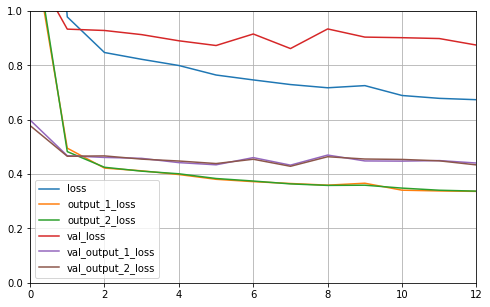

In [11]:
# 把值的变化过程打印出来
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [12]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],[y_test,y_test])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7983249344566996, 0.39803588, 0.40433988]